In [17]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import copy

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

## Making Class for Soft But Hard Decision Tree - Static Building/End2End

In [18]:
class LeafNode(object):
    
    def __init__(self, output_dim, optimizer):
        self.output_dim = output_dim
        self.optimizer = optimizer
        self.constant = tnn.BiasLayer(self.output_dim, optimizer=self.optimizer)
        
    def forward(self, inputs):
        out = np.zeros(shape=(inputs.shape[0], self.output_dim))
        return self.constant.forward(out)
    
    def backward(self, del_outputs):
        self.constant.backward(del_outputs)
        return del_outputs
    
    def update(self):
        self.constant.update()

class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.node0 = None
        self.node1 = None
        self.linear = tnn.LinearLayer(input_dim, output_dim, optimizer=optimizer)
        self.linear.weights *= 0
        self.sigmoid = tnn.Sigmoid()
        
        self.mask = None
        self.out0 = None
        self.out1 = None
        
    def forward(self, inputs):
        lout = self.linear.forward(inputs)
        self.sigmoid.forward(lout)
        
        self.mask = (lout>0).astype(lout.dtype)
        self.out0 = self.node0.forward(inputs)
        self.out1 = self.node1.forward(inputs)
        
        return self.out0*self.mask + self.out1*(1-self.mask)
    
    def backward(self, del_outputs):
        del_out0 = del_outputs*self.mask
        del_out1 = del_outputs*(1-self.mask)
        
        self.node0.backward(del_out0)
        self.node1.backward(del_out1)
        
        self.linear.backward(self.sigmoid.backward(del_outputs.mean(axis=1, keepdims=True)))
        return del_outputs
    
    def update(self):
        self.linear.update()
        self.node0.update()
        self.node1.update()
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node1 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self.output_dim, self.optimizer)
            self.node1 = LeafNode(self.output_dim, self.optimizer)

## 1D regression

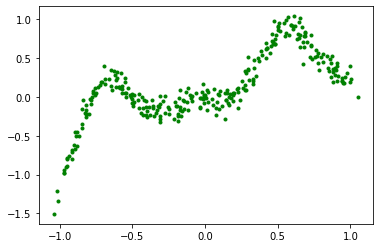

In [38]:
np.random.seed(12)
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [39]:
optimizer = tnn.Adam()
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=3)

In [40]:
yout = hdt.forward(xx)

In [41]:
xx.shape, yout.shape

((300, 1), (300, 1))

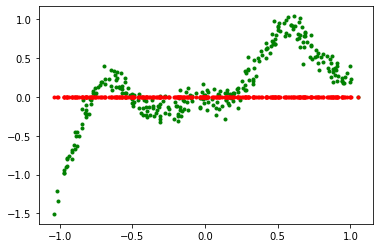

In [42]:
%matplotlib inline

plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), marker='.', color='r')
plt.show()

In [43]:
optimizer = tnn.Adam()
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=3)

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, yout.reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.20385006202675826


100 Error =  0.13397506525843483


200 Error =  0.11659039763443219


300 Error =  0.10195375154645689


400 Error =  0.0952122586405116


500 Error =  0.08885475127920937


600 Error =  0.07358165280998905


700 Error =  0.06268422859762997


800 Error =  0.05916546453834123


900 Error =  0.05719944642910427


1000 Error =  0.05352642627395318


1100 Error =  0.053577739105773244


1200 Error =  0.04980377523414363


1300 Error =  0.0467478922876966


1400 Error =  0.04438892847660316


1500 Error =  0.04244525347538674


1600 Error =  0.04147531541577924


1700 Error =  0.040895488589457865


1800 Error =  0.040979617153976744


1900 Error =  0.039518284809421815


2000 Error =  0.03892635213440051


2100 Error =  0.03909184505131761


2200 Error =  0.03830329828478146


2300 Error =  0.03843415964519416


2400 Error =  0.03793834716771119


2500 Error =  0.037097525738237686


2600 Error =  0.03692722314879615


2700 Error =  0.03671626526749645


2

TclError: invalid command name "pyimage72"

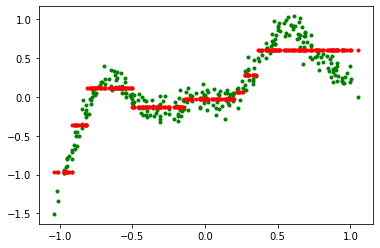

In [44]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), color='r', marker='.')

## On 2D dataset

In [45]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [46]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

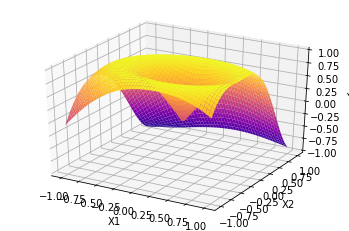

In [47]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [48]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Building Decision Tree

In [49]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=3)

In [50]:
yout = hdt.forward(xx)

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1530, in _draw
    def _draw(renderer): raise D

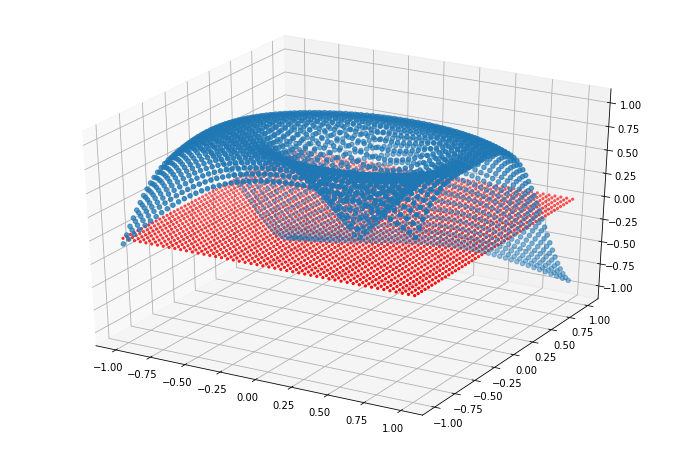

In [51]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()

In [52]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=3)

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5639648664243325


100 Error =  0.08248262480664001


200 Error =  0.06577687487417662


300 Error =  0.0660024922330518


400 Error =  0.06905089550134821


500 Error =  0.07039850095023338


600 Error =  0.07302158708463562


700 Error =  0.07666524925447656


800 Error =  0.06447075836524042


900 Error =  0.054714190348789146


1000 Error =  0.05165050766605609


1100 Error =  0.047140934177332915


1200 Error =  0.04286191308380703


1300 Error =  0.04221633216953625


1400 Error =  0.042000002504966015


1500 Error =  0.03949076185651415


1600 Error =  0.03800750120486547


1700 Error =  0.03673398509092426


1800 Error =  0.035666702304203095


1900 Error =  0.03524483847436347


2000 Error =  0.034735256167381996


2100 Error =  0.03460654673952264


2200 Error =  0.034660402817892295


2300 Error =  0.0353125630573399


2400 Error =  0.03542641188447722


2500 Error =  0.03592830614783168


2600 Error =  0.036985481626782835


2700 Error =  0.03687247353831552




TclError: invalid command name "pyimage92"

/home/tsuman/Program_Files/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


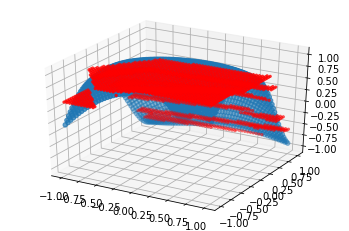

In [21]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()

## Vanilla Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(max_depth=4)

In [ ]:
dtr.fit(xx, yy)

In [ ]:
yout = dtr.predict(xx)

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
fig.show()